In [1]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import torch
from torch import nn
from copy import deepcopy
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Subset
from torchvision import transforms, datasets, models
from torchvision.models import resnet50, densenet121, inception_v3
from torchsummary import summary
from collections import OrderedDict
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import seaborn as sns
import wandb
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold

In [2]:
BATCH_SIZE = 4

In [3]:
class AugmentedDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=False):
        self.dataset = datasets.ImageFolder(root_dir)
        self.transform = transform
        self.train = train
        self.classes = self.dataset.classes
        self.class_to_idx = self.dataset.class_to_idx
        
        self.augment_classes = ['None', 'Many']
        self.augment_indices = [self.class_to_idx[cls] for cls in self.augment_classes if cls in self.class_to_idx]
        
        # Count samples per class
        self.class_counts = [0] * len(self.classes)
        for _, label in self.dataset.samples:
            self.class_counts[label] += 1
        
        # Calculate class weights once
        total_samples = sum(self.class_counts)
        self.class_weights = [total_samples / (len(self.class_counts) * count) for count in self.class_counts]
        
        if self.train:
            self.train_augs = A.Compose([
                A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),  # Reduced limits
                A.GaussNoise(var_limit=(5.0, 20.0), p=0.3),  # Reduced upper var_limit
                A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.1, rotate_limit=10, p=0.5),])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        
        if self.train and label in self.augment_indices:
            img_np = np.array(img)
            augmented = self.train_augs(image=img_np)
            img_np = augmented['image']
            img = Image.fromarray(img_np)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

    def get_sample_weights(self):
        return [self.class_weights[label] for _, label in self.dataset.samples]

In [4]:
def create_weighted_sampler(dataset, indices):
    sample_weights = dataset.get_sample_weights()
    subset_weights = [sample_weights[i] for i in indices]
    return WeightedRandomSampler(subset_weights, len(subset_weights), replacement=True)

# Define your transformations
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Create full datasets
full_dataset = AugmentedDataset('data', transform=transform)
print(len(full_dataset))
print(full_dataset.class_counts)
print(sum(full_dataset.class_counts))
dummy_loader = DataLoader(full_dataset, batch_size=1, shuffle=True)

8724
[6232, 256, 2236]
8724


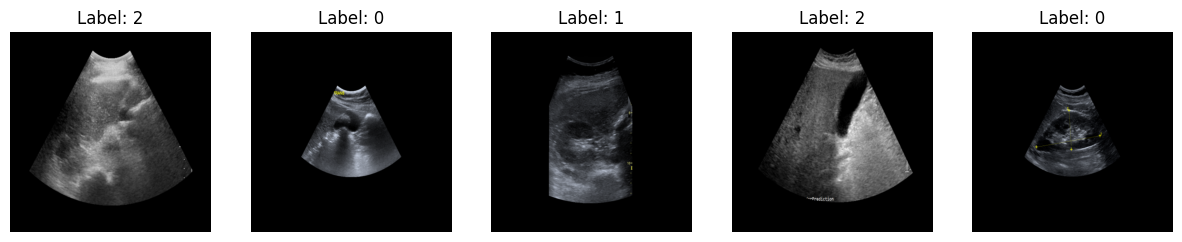

In [5]:
# Function to get images of a specific label
def get_images_by_label(dataloader, num_images=1, label=None):
    images = []
    labels = []
    if label is None:
        # Get random images not considering the label
        for batch_images, batch_labels in dataloader:
            for img, lbl in zip(batch_images, batch_labels):
                images.append(img)
                labels.append(lbl)
                if len(images) >= num_images:
                    return images, labels
    for batch_images, batch_labels in dataloader:
        for img, lbl in zip(batch_images, batch_labels):
            if lbl == label:
                images.append(img)
                labels.append(lbl)
                if len(images) >= num_images:
                    return images, labels
    return images, labels

# Example usage: Get 5 images of label 0
label_to_display = 2
num_images_to_display = 5
images, labels = get_images_by_label(dummy_loader, num_images_to_display, label=None)

# Display the images
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))
for i, (img, lbl) in enumerate(zip(images, labels)):
    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].set_title(f'Label: {lbl}')
    axes[i].axis('off')
plt.show()

In [6]:
num_class = len(dummy_loader.dataset.classes)
print(num_class)
print(dummy_loader.dataset.classes)

3
['Few', 'Many', 'None']


In [7]:
class_weights = torch.tensor(full_dataset.class_weights, dtype=torch.float)
print(class_weights)
print(full_dataset.classes)

tensor([ 0.4666, 11.3594,  1.3005])
['Few', 'Many', 'None']


In [8]:
for batch in dummy_loader:
    print(batch)
    break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]]), tensor([0])]


In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score


def calculate_metrics(y_true, y_pred, y_prob, train=False):

    if train:
        auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        return auc, f1
    
    cm = confusion_matrix(y_true, y_pred)

    # Calculate metrics for each class
    metrics = []
    sensitivities = []
    specificities = []
    precisions = []
    
    for i in range(len(cm)):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - TP - FP - FN
        
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        precisions.append(precision)
        
        metrics.append({
            'sensitivity': sensitivity,
            'specificity': specificity,
            'precision': precision
        })
    
    # Calculate overall accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate ROC-AUC and F1 score for validation set
    auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Calculate averaged sensitivity and specificity
    avg_sensitivity = sum(sensitivities) / len(sensitivities) if sensitivities else 0
    avg_specificity = sum(specificities) / len(specificities) if specificities else 0
    
    return accuracy, metrics, auc, f1, cm, avg_sensitivity, avg_specificity

def plot_confusion_matrix(cm, class_names, epoch_num=0, model_name='model', fold_num=0):
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'figures/confusion_matrix_{model_name}_epoch_{epoch_num}_fold{fold_num}.png')
    plt.close()

def custom_log(metrics, model_name, log_dir='logs'):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    log_file = f'{log_dir}/{model_name}_metrics_log.json'
    with open(log_file, 'a') as f:
        f.write(json.dumps(metrics) + '\n')

In [10]:
import torch
import torch.nn.functional as F
import numpy as np
import wandb

def train_model(model, criterion, optimizer, train_loader, val_loader, class_names, num_epochs=30, device='cuda', model_name='model', fold=0):
    wandb.init(project="Hepatocyte Ballooning Detection", name=f"RadImageNet {model_name} Fold {fold+1}")
    wandb.watch(model, criterion, log='all')

    print(f'Training {model_name} for {num_epochs} epochs on Fold {fold+1}')
    max_f1 = 0
    best_metrics = {}
    
    for e in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_preds, train_labels, train_probs = [], [], []


        for i_batch, batch in enumerate(train_loader):
            data, labels = batch[0].to(device, dtype=torch.float), batch[1].to(device)
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            probs = F.softmax(outputs, dim=1)  # Get probabilities

            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
            train_probs.extend(probs.detach().cpu().numpy())  # Store probabilities

        # Calculate metrics
        train_auc, train_f1 = calculate_metrics(train_labels, train_preds, train_probs, train=True)


        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds, val_labels, val_probs = [], [], []

        with torch.no_grad():
            for i_batch, batch in enumerate(val_loader):
                data, labels = batch[0].to(device, dtype=torch.float), batch[1].to(device)
                
                outputs = model(data)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * data.size(0)

                probs = F.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_probs.extend(probs.cpu().numpy())

        # Calculate metrics
        val_accuracy, val_class_metrics, val_auc, val_f1, val_cm, avg_sensitivity, avg_specificity = calculate_metrics(val_labels, val_preds, val_probs)

        print(f'Epoch {e+1}')
        val_loss /= len(val_loader.dataset)
        train_loss /= len(train_loader.dataset)
        print(f'Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.4f}')
        print(f'Validation AUC: {val_auc:.4f}')
        print(f'Macro-averaged F1 Score: {val_f1:.4f}')
        print(f'Averaged Sensitivity: {avg_sensitivity:.4f}, Averaged Specificity: {avg_specificity:.4f}')
        for i, metrics in enumerate(val_class_metrics):
            print(f'Class {class_names[i]} - Sensitivity: {metrics["sensitivity"]:.4f}, Specificity: {metrics["specificity"]:.4f}')

        # Log metrics to wandb and custom logger
        metrics = {
            'fold': fold + 1,
            'epoch': e + 1,
            'train_loss': train_loss,
            'train_auc': train_auc,
            'train_f1': train_f1,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'val_auc': val_auc,
            'val_f1': val_f1,
            'avg_sensitivity': avg_sensitivity,
            'avg_specificity': avg_specificity,
            **{f'class_{class_names[i]}_sensitivity': metrics["sensitivity"] for i, metrics in enumerate(val_class_metrics)},
            **{f'class_{class_names[i]}_specificity': metrics["specificity"] for i, metrics in enumerate(val_class_metrics)},
            **{f'class_{class_names[i]}_f1': 2 * metrics["precision"] * metrics["sensitivity"] / (metrics["precision"] + metrics["sensitivity"]) for i, metrics in enumerate(val_class_metrics)}
        }

        # Log to wandb
        wandb.log(metrics)

        # Log to custom logger
        custom_log(metrics, model_name)

        # Save the last model and delete one before it to chekpoint directory
        torch.save(model.state_dict(), f'checkpoints/last_{model_name}_epoch_{e+1}_fold_{fold+1}.pth')
        if e > 0:
            os.remove(f'checkpoints/last_{model_name}_epoch_{e}_fold_{fold+1}.pth')
        
        # Save the best model
        if max_f1 < val_f1:
            print(f'Macro F1 Increased({max_f1:.6f}--->{val_f1:.6f}) \t Saving The Model')
            max_f1 = val_f1
            best_metrics = deepcopy(metrics)
            torch.save(model.state_dict(), f'checkpoints/best/best_{model_name}_epoch_{e+1}_fold_{fold+1}.pth')
            
            # Plot confusion matrix for the best model
            plot_confusion_matrix(val_cm, class_names, e+1, model_name, fold+1)

    return model, best_metrics

In [11]:
models = os.listdir('models')
print(models)
model_name = models[2] # InceptionV3

['ResNet50.pt', 'DenseNet121.pt', 'InceptionV3.pt']


In [12]:
# Define the path to the data
data_path = 'data'

# List the folders in the data path
folders = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]

# Initialize a dictionary to store the count of images in each folder
image_counts = {}

# Iterate through each folder and count the number of image files
for folder in folders:
    folder_path = os.path.join(data_path, folder)
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    image_counts[folder] = len(image_files)

# Display the results
for folder, count in image_counts.items():
    print(f'Folder: {folder}, Number of images: {count}')

Folder: Many, Number of images: 256
Folder: None, Number of images: 2236
Folder: Few, Number of images: 6232


In [13]:
# Make all the needed directories
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('checkpoints/best', exist_ok=True)
os.makedirs('logs', exist_ok=True)
os.makedirs('logs/best', exist_ok=True)
os.makedirs('figures', exist_ok=True)

In [14]:
from torchvision.models import efficientnet_b0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_metrics_lst = []

base_model = efficientnet_b0(weights=None)
base_model.classifier[1] = nn.Linear(base_model.classifier[1].in_features, num_class)
model_name = 'EfficientNetB0 Adam'

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# start from 2nd fold
for fold, (train_idx, val_idx) in enumerate(skf.split(full_dataset, full_dataset.dataset.targets)):
	print(f"Fold {fold + 1}")
	
	# Create training and validation subsets
	train_subset = Subset(full_dataset, train_idx)
	val_subset = Subset(full_dataset, val_idx)
	
	sampler = create_weighted_sampler(full_dataset, train_idx)

	# Create DataLoaders
	train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler)
	val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
	
	# Create a deep copy of the model for this fold
	model = deepcopy(base_model)
	model = model.to(device)

	# Define loss function and optimizer
	criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
	optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

	# Train the model
	model, best_metrics = train_model(model, criterion, optimizer, train_loader, val_loader, full_dataset.dataset.classes, num_epochs=30, device=device, model_name=model_name, fold=fold)
	best_metrics_lst.append(best_metrics)
	custom_log(best_metrics, model_name + '_best', log_dir='logs/best')
	print(f"Best Validation Metrics of Fold {fold+1}:")
	print(f"Accuracy: {best_metrics['val_accuracy']:.4f}")
	print(f"AUC: {best_metrics['val_auc']:.4f}")
	print(f'Macro-averaged F1 Score: {best_metrics["val_f1"]:.4f}')
	print(f'Averaged Sensitivity: {best_metrics["avg_sensitivity"]:.4f}, Averaged Specificity: {best_metrics["avg_specificity"]:.4f}')
	
	wandb.finish()

Fold 1


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: samwellwatwat. Use `wandb login --relogin` to force relogin


Training EfficientNetB0 Adam for 30 epochs on Fold 1
Epoch 1
Training Loss: 0.1995, Validation Loss: 1.7601
Validation Accuracy: 0.0802
Validation AUC: 0.5693
Macro-averaged F1 Score: 0.0451
Averaged Sensitivity: 0.4003, Averaged Specificity: 0.6516
Class Few - Sensitivity: 0.0000, Specificity: 1.0000
Class Many - Sensitivity: 1.0000, Specificity: 0.3738
Class None - Sensitivity: 0.2009, Specificity: 0.5809
Macro F1 Increased(0.000000--->0.045150) 	 Saving The Model
Epoch 2
Training Loss: 0.1872, Validation Loss: 2.0791
Validation Accuracy: 0.0871
Validation AUC: 0.5831
Macro-averaged F1 Score: 0.0489
Averaged Sensitivity: 0.4092, Averaged Specificity: 0.6518
Class Few - Sensitivity: 0.0000, Specificity: 1.0000
Class Many - Sensitivity: 1.0000, Specificity: 0.4021
Class None - Sensitivity: 0.2277, Specificity: 0.5532
Macro F1 Increased(0.045150--->0.048892) 	 Saving The Model
Epoch 3
Training Loss: 0.1737, Validation Loss: 1.3378
Validation Accuracy: 0.1672
Validation AUC: 0.6138
Macro

avg_sensitivity,▁▁▄▄▇▇▅▄▅▅▅▅▇▄▆▆▆▄▄▅█▆▇▆▇▇▆▆▆█
avg_specificity,▁▁▁▂▆▆▂▂▂▅▂▃▆▃▃▃▄▂▂▄▆▄█▃▄█▄▅▇█
class_Few_f1,▁▁▁▁▇█▁▁▁▆▁▂▇▂▂▃▅▁▁▄▇▄█▃▅█▃▅██
class_Few_sensitivity,▁▁▁▁▇█▁▁▁▅▁▂▆▂▂▃▄▁▁▃▆▃▇▃▄▇▂▄▇█
class_Few_specificity,████▂▁███▅██▃▇▇▆▅██▇▃▆▃▇▆▄█▆▂▁
class_Many_f1,▁▂▇▆▇▇█▇▇▄▆▆▆▅█▇▆▄▅▄█▆▄▆▇▄▇▅▂▆
class_Many_sensitivity,███▅▇▇▆▅▅▃▄▄▄▃▅▅▄▂▃▂▅▃▂▄▅▂▄▃▁▄
class_Many_specificity,▁▁▅▇▅▅▆▇▇█▇▇▇███▇████▇█▇██████
class_None_f1,▄▄▅▃▆▆▃▂▂▆▃▃▇▃▃▄▅▁▁▄▇▅█▄▅█▃▆██
class_None_sensitivity,▁▁▄▆▃▂▆▇▇▆▇▇▆██▇▆███▆▇▆▇▇▆█▇▆▅
class_None_specificity,▆▅▃▂▇█▂▂▂▄▂▂▅▂▂▂▃▁▁▂▅▃▅▃▃▅▂▃▅▆


Fold 2


Training EfficientNetB0 Adam for 30 epochs on Fold 2
Epoch 1
Training Loss: 0.1984, Validation Loss: 1.8651
Validation Accuracy: 0.0859
Validation AUC: 0.5624
Macro-averaged F1 Score: 0.0519
Averaged Sensitivity: 0.3840, Averaged Specificity: 0.6549
Class Few - Sensitivity: 0.0000, Specificity: 1.0000
Class Many - Sensitivity: 0.9200, Specificity: 0.3667
Class None - Sensitivity: 0.2321, Specificity: 0.5978
Macro F1 Increased(0.000000--->0.051945) 	 Saving The Model
Epoch 2
Training Loss: 0.1807, Validation Loss: 1.6340
Validation Accuracy: 0.1271
Validation AUC: 0.5939
Macro-averaged F1 Score: 0.0722
Averaged Sensitivity: 0.4258, Averaged Specificity: 0.6590
Class Few - Sensitivity: 0.0000, Specificity: 1.0000
Class Many - Sensitivity: 0.8800, Specificity: 0.5071
Class None - Sensitivity: 0.3973, Specificity: 0.4700
Macro F1 Increased(0.051945--->0.072226) 	 Saving The Model
Epoch 3
Training Loss: 0.1772, Validation Loss: 1.5688
Validation Accuracy: 0.1352
Validation AUC: 0.5801
Macro

avg_sensitivity,▁▂▂▃▄▄▆▄▅▇▇▆█▆▅▇▄▄▅▆▄▄▅▃▅▅▇▇▆▆
avg_specificity,▁▁▁▁▁▁▄▂▂▃▆▃▆▅▄▇▂▂▃▅▂▂▄▃▃▃▇▆▅█
class_Few_f1,▁▁▁▁▁▁▄▁▂▃▆▃▇▅▄▇▂▁▃▅▂▂▄▃▃▃▇▆▅█
class_Few_sensitivity,▁▁▁▁▁▁▃▁▂▂▅▂▆▄▃▆▁▁▂▄▁▂▃▂▂▂▇▅▄█
class_Few_specificity,██████▆██▇▅▇▃▆▇▃▇█▇▅██▇▆██▃▆▆▁
class_Many_f1,▃▅▆▇▇▇▇▇▆█▆▇▇▆▅▅▅▆▅▅▅▅▅▃▄▆▄▆▅▁
class_Many_sensitivity,██▇██▇▆▆▅▇▄▆▆▅▃▃▃▄▄▃▃▄▃▂▃▅▃▄▃▁
class_Many_specificity,▁▃▃▄▄▅▆▆▇▇▇▆▇▇▇██▇▇██▆▇██▇█▇▇█
class_None_f1,▄▅▅▄▄▄▅▃▃▄▆▅▇▅▄▇▁▂▃▅▁▄▅▃▂▃▇▆▅█
class_None_sensitivity,▁▃▃▃▃▄▆▆▇▆▇▆▅▆▇▆█▇▇▇█▆▇▇█▇▆▇▇▆
class_None_specificity,█▆▆▅▅▄▅▃▂▃▅▄▇▅▃▇▁▂▂▄▁▃▄▂▂▃▇▅▄█


Fold 3


Training EfficientNetB0 Adam for 30 epochs on Fold 3
Epoch 1
Training Loss: 0.2048, Validation Loss: 1.9215
Validation Accuracy: 0.1787
Validation AUC: 0.5506
Macro-averaged F1 Score: 0.2433
Averaged Sensitivity: 0.4086, Averaged Specificity: 0.6906
Class Few - Sensitivity: 0.1990, Specificity: 0.8960
Class Many - Sensitivity: 1.0000, Specificity: 0.2113
Class None - Sensitivity: 0.0268, Specificity: 0.9646
Macro F1 Increased(0.000000--->0.243274) 	 Saving The Model
Epoch 2
Training Loss: 0.1810, Validation Loss: 1.5965
Validation Accuracy: 0.0859
Validation AUC: 0.6067
Macro-averaged F1 Score: 0.0515
Averaged Sensitivity: 0.4062, Averaged Specificity: 0.6570
Class Few - Sensitivity: 0.0000, Specificity: 1.0000
Class Many - Sensitivity: 1.0000, Specificity: 0.3424
Class None - Sensitivity: 0.2188, Specificity: 0.6287
Epoch 3
Training Loss: 0.1717, Validation Loss: 1.6147
Validation Accuracy: 0.1455
Validation AUC: 0.5995
Macro-averaged F1 Score: 0.0748
Averaged Sensitivity: 0.4723, Ave

avg_sensitivity,▁▁▃▃▅▄▄▅▅▄▃▅▇▇▇▆▃▅▅▅█▄█▅█▅▅▇▆▄
avg_specificity,▃▁▁▁▃▂▁▃▂▂▂▂▄▄▇▆▂▃▄▅▆▄▆▅█▄▄▇▆▄
class_Few_f1,▄▁▁▂▄▂▁▃▃▁▂▂▄▅▇▇▂▄▅▅▇▅▇▆█▄▄▇▇▅
class_Few_sensitivity,▃▁▁▁▃▁▁▂▂▁▂▁▃▄▇▆▁▃▄▄▆▃▇▄█▃▃▆▆▄
class_Few_specificity,▅██▇▆██▇▇█▇█▆▄▁▂█▆▅▅▃▆▂▅▂▇▆▃▃▆
class_Many_f1,▁▃▇▇▇▇██▇▇▇▇██▇▇▆▇▇▆▇▆▇▅▆▆▆▇▇▅
class_Many_sensitivity,█████▇▆▇▄▅▅▄▆▄▄▃▂▃▄▂▄▂▄▁▂▂▂▃▄▁
class_Many_specificity,▁▂▅▅▅▅▆▆▇▆▆▇▇█▇▇▇█▇█████████▇█
class_None_f1,▁▄▅▅▆▅▅▆▄▄▅▄▆▆▇▇▃▄▆▆▇▅▇▆█▄▅▇▇▆
class_None_sensitivity,▁▃▄▄▅▆▆▆▇▇▆█▇▇▅▆██▆▇▆▇▆▇▆██▇▅█
class_None_specificity,█▅▃▃▄▃▂▃▂▂▃▁▃▃▆▅▁▂▃▃▅▂▅▃▆▂▂▄▆▂


Fold 4


Training EfficientNetB0 Adam for 30 epochs on Fold 4
Epoch 1
Training Loss: 0.1904, Validation Loss: 1.7448
Validation Accuracy: 0.0825
Validation AUC: 0.6006
Macro-averaged F1 Score: 0.0517
Averaged Sensitivity: 0.3791, Averaged Specificity: 0.6575
Class Few - Sensitivity: 0.0000, Specificity: 1.0000
Class Many - Sensitivity: 0.9231, Specificity: 0.3223
Class None - Sensitivity: 0.2143, Specificity: 0.6502
Macro F1 Increased(0.000000--->0.051654) 	 Saving The Model
Epoch 2
Training Loss: 0.1740, Validation Loss: 1.4158
Validation Accuracy: 0.2818
Validation AUC: 0.6154
Macro-averaged F1 Score: 0.3355
Averaged Sensitivity: 0.5036, Averaged Specificity: 0.6908
Class Few - Sensitivity: 0.2456, Specificity: 0.8800
Class Many - Sensitivity: 0.9615, Specificity: 0.6316
Class None - Sensitivity: 0.3036, Specificity: 0.5609
Macro F1 Increased(0.051654--->0.335512) 	 Saving The Model
Epoch 3
Training Loss: 0.1590, Validation Loss: 1.5231
Validation Accuracy: 0.1329
Validation AUC: 0.6068
Macro

avg_sensitivity,▁▅▃▄▄▄▇▅▅▇█▇▇█▆▄█▇▆▇▇▅█▇▆▅▇▇▇▆
avg_specificity,▁▃▁▁▃▁▄▃▃▅▅▅▅▆▇▃█▇▅▅▇▅█▇▇▄▇█▆▆
class_Few_f1,▁▅▁▂▅▁▅▄▃▆▇▇▆▇█▄█▇▆▆▇▆██▇▄▇█▇▇
class_Few_sensitivity,▁▃▁▁▃▁▄▃▂▄▆▅▅▅▇▃▇▆▄▄▆▄█▆▅▃▅▇▅▅
class_Few_specificity,█▆██▆█▆▆▇▅▂▅▅▅▃▆▂▄▆▆▅▆▁▄▆▇▅▃▅▅
class_Many_f1,▁▇▆▆▅▇▇▇▆▇█▆▇▇▁▃▅▅▄▇▅▂▅▄▃▃▅▂▆▂
class_Many_sensitivity,████▇██▅▅▆▇▅▅▅▁▂▃▃▃▅▃▁▃▂▂▂▃▁▄▁
class_Many_specificity,▁▄▃▄▃▄▅▆▆▆▅▆▇▇███▇█▇████████▇█
class_None_f1,▁▂▃▃▄▃▅▄▄▆▃▆▆▇▇▃▇▇▅▅▇▅▇█▇▃▇█▇▆
class_None_sensitivity,▁▂▃▃▃▄▃▅▆▅▂▅▆▆▆▇▅▆▇▆▆█▄▆▇█▆▆▆▇
class_None_specificity,▅▄▃▃▆▂▅▂▂▅█▅▄▅▆▁▇▅▃▃▄▃█▅▄▁▄▇▅▃


Fold 5


Training EfficientNetB0 Adam for 30 epochs on Fold 5
Epoch 1
Training Loss: 0.1917, Validation Loss: 1.4240
Validation Accuracy: 0.1273
Validation AUC: 0.5888
Macro-averaged F1 Score: 0.0691
Averaged Sensitivity: 0.4377, Averaged Specificity: 0.6565
Class Few - Sensitivity: 0.0000, Specificity: 1.0000
Class Many - Sensitivity: 0.9231, Specificity: 0.5319
Class None - Sensitivity: 0.3901, Specificity: 0.4376
Macro F1 Increased(0.000000--->0.069131) 	 Saving The Model
Epoch 2
Training Loss: 0.1863, Validation Loss: 1.7311
Validation Accuracy: 0.1181
Validation AUC: 0.6152
Macro-averaged F1 Score: 0.0818
Averaged Sensitivity: 0.4275, Averaged Specificity: 0.6541
Class Few - Sensitivity: 0.0161, Specificity: 0.9839
Class Many - Sensitivity: 0.9615, Specificity: 0.4823
Class None - Sensitivity: 0.3049, Specificity: 0.4961
Macro F1 Increased(0.069131--->0.081758) 	 Saving The Model
Epoch 3
Training Loss: 0.1680, Validation Loss: 1.5041
Validation Accuracy: 0.1170
Validation AUC: 0.6215
Macro

avg_sensitivity,▂▂▂▁▂▃▅▅▅▄▅▅▆▅▆▅▅▄▅▇▆▇▆▅▄▆█▅▆▇
avg_specificity,▁▁▁▁▁▁▅▃▂▂▂▄▆▃▆▂▄▃▃▇▆▇▅▃▂▇█▅▆▆
class_Few_f1,▁▁▁▁▁▁▆▃▂▁▁▄▇▂▇▁▅▂▄▇▇▇▅▃▁▇█▅▆▆
class_Few_sensitivity,▁▁▁▁▁▁▄▂▁▁▁▃▇▂▆▁▄▂▃▆▆▆▄▂▁▆█▄▅▄
class_Few_specificity,██████▅▇███▆▁▇▃█▅▇▆▃▃▅▆▆█▄▁▅▅▇
class_Many_f1,▅▄▅▁▆▆▇▇▇▇█▇▇█▇▇▆▆▆▇▇▇▇▇▇▆█▆▆▇
class_Many_sensitivity,▇█▇█▆█▇▇▆▆▆▅▆▅▅▄▂▁▂▅▅▄▃▄▂▂▅▂▂▅
class_Many_specificity,▄▃▄▁▄▅▅▆▆▆▇▆▇▇▇▇▇██▇▆█████████
class_None_f1,▅▄▄▃▅▅▆▅▄▄▃▆▇▃▇▂▆▃▄█▇▇▅▄▁▇█▅▆▆
class_None_sensitivity,▃▂▂▁▄▄▄▆▆▆▇▆▄▇▆▇▇█▇▆▅▇▇▇█▇▅▇▇▇
class_None_specificity,▅▆▅█▄▄▆▃▃▃▂▄█▂▆▁▄▂▃▇▇▆▄▃▁▅█▄▅▅


Fold 6


Training EfficientNetB0 Adam for 30 epochs on Fold 6
Epoch 1
Training Loss: 0.1936, Validation Loss: 1.6280
Validation Accuracy: 0.1881
Validation AUC: 0.5934
Macro-averaged F1 Score: 0.2331
Averaged Sensitivity: 0.4513, Averaged Specificity: 0.6802
Class Few - Sensitivity: 0.1477, Specificity: 0.9237
Class Many - Sensitivity: 1.0000, Specificity: 0.4113
Class None - Sensitivity: 0.2063, Specificity: 0.7057
Macro F1 Increased(0.000000--->0.233065) 	 Saving The Model
Epoch 2
Training Loss: 0.1778, Validation Loss: 1.1262
Validation Accuracy: 0.3933
Validation AUC: 0.6389
Macro-averaged F1 Score: 0.4066
Averaged Sensitivity: 0.4382, Averaged Specificity: 0.7148
Class Few - Sensitivity: 0.2761, Specificity: 0.8835
Class Many - Sensitivity: 0.3077, Specificity: 0.8972
Class None - Sensitivity: 0.7309, Specificity: 0.3636
Macro F1 Increased(0.233065--->0.406550) 	 Saving The Model
Epoch 3
Training Loss: 0.1655, Validation Loss: 1.1957
Validation Accuracy: 0.1835
Validation AUC: 0.6202
Macro

avg_sensitivity,▃▃▅▄█▄▄▄▄▅▃▅▃▃▃▁▅▄▆▄▄▅▅▃▂▂▆▅▆▅
avg_specificity,▂▄▁▂▅▁▂▂▂▆▄▅▂▄▅▂▅▄▇▅▃▅▆▄▂▄█▆▇▆
class_Few_f1,▄▅▂▂▇▁▃▁▃▆▆▆▂▄▆▃▆▅█▆▄▆▇▅▃▅█▆▇▇
class_Few_sensitivity,▃▄▂▁▆▁▂▁▂▅▄▅▁▃▄▂▅▄█▅▃▄▆▃▂▄█▅▆▆
class_Few_specificity,▆▅▇▇▂█▇█▆▄▅▅█▆▅▇▄▆▁▅▆▅▃▆▇▆▂▆▄▄
class_Many_f1,▅▄█▇██▇▇▇▄▄▅▆▄▂▁▄▄▄▃▄▅▂▃▄▂▂▃▃▄
class_Many_sensitivity,█▂█▅█▇▅▅▅▃▂▃▄▂▂▁▃▃▃▂▃▃▂▂▃▁▂▂▂▃
class_Many_specificity,▁▇▄▆▄▄▆▆▆▇▇▇▅▇██▇█▇██▇██▇████▇
class_None_f1,▂▅▄▃▄▄▄▃▄▇▅▆▃▄▅▁▆▄█▅▃▅▇▄▁▄█▆▇▇
class_None_sensitivity,▁▆▃▆▂▄▆▆▆▆▆▆▆▇▇█▆▇▅▇▇▆▇▇▇▇▅▇▇▆
class_None_specificity,▇▄▄▂█▃▃▂▃▅▄▄▂▃▃▁▄▃▇▄▂▄▅▂▁▂▇▄▅▅


Fold 7


Training EfficientNetB0 Adam for 30 epochs on Fold 7
Epoch 1
Training Loss: 0.1955, Validation Loss: 1.6713
Validation Accuracy: 0.1663
Validation AUC: 0.5641
Macro-averaged F1 Score: 0.1791
Averaged Sensitivity: 0.4358, Averaged Specificity: 0.6690
Class Few - Sensitivity: 0.0883, Specificity: 0.9357
Class Many - Sensitivity: 0.9231, Specificity: 0.4504
Class None - Sensitivity: 0.2960, Specificity: 0.6210
Macro F1 Increased(0.000000--->0.179117) 	 Saving The Model
Epoch 2
Training Loss: 0.1777, Validation Loss: 3.8581
Validation Accuracy: 0.0344
Validation AUC: 0.4928
Macro-averaged F1 Score: 0.0104
Averaged Sensitivity: 0.3393, Averaged Specificity: 0.6672
Class Few - Sensitivity: 0.0000, Specificity: 1.0000
Class Many - Sensitivity: 1.0000, Specificity: 0.0154
Class None - Sensitivity: 0.0179, Specificity: 0.9861
Epoch 3
Training Loss: 0.1723, Validation Loss: 1.5696
Validation Accuracy: 0.1835
Validation AUC: 0.5977
Macro-averaged F1 Score: 0.0924
Averaged Sensitivity: 0.5336, Ave

avg_sensitivity,▄▁▆▆▆█▆▇▇▆▅▆▆▇▆▆▆▅▄▇▆██▇▇▇█▇▇▇
avg_specificity,▁▁▁▁▁▃▁▁▁▁▁▃▃▄▃▂▃▃▃▇▃█▇▅▄▄▇▅▅▆
class_Few_f1,▃▁▁▁▁▄▁▁▁▂▁▃▃▄▃▂▃▃▃▇▃█▇▆▅▅█▅▅▆
class_Few_sensitivity,▂▁▁▁▁▃▁▁▁▁▁▂▂▃▂▂▂▂▂▆▂█▆▅▃▃█▄▄▅
class_Few_specificity,▆████▄███▇██▇▇▇███▇▃▇▁▄▃▆▇▂▆▆▆
class_Many_f1,▆▁▇▇█████▇▆▇▇▇▇▇▇▅▅▅▇▆▆▇▆▇▆▆▆▆
class_Many_sensitivity,▇████▆▇▆▇▅▃▃▄▃▃▃▃▁▁▁▃▂▃▃▃▄▃▃▂▂
class_Many_specificity,▄▁▆▆▆▇▆█▇▇████████████████████
class_None_f1,▅▁▅▅▅▆▅▂▄▄▂▄▄▅▄▃▃▃▄▇▄█▇▆▅▅█▆▅▆
class_None_sensitivity,▃▁▅▅▅▇▆█▇▇██▇▇▇███▇▇█▆▇▇▇█▆███
class_None_specificity,▅█▃▃▃▃▂▁▂▂▁▂▂▂▂▁▁▁▂▄▂▆▄▄▃▃▅▃▃▃


Fold 8


Training EfficientNetB0 Adam for 30 epochs on Fold 8
Epoch 1
Training Loss: 0.1983, Validation Loss: 1.6854
Validation Accuracy: 0.1044
Validation AUC: 0.5825
Macro-averaged F1 Score: 0.0661
Averaged Sensitivity: 0.4286, Averaged Specificity: 0.6609
Class Few - Sensitivity: 0.0032, Specificity: 1.0000
Class Many - Sensitivity: 1.0000, Specificity: 0.3865
Class None - Sensitivity: 0.2825, Specificity: 0.5963
Macro F1 Increased(0.000000--->0.066088) 	 Saving The Model
Epoch 2
Training Loss: 0.1711, Validation Loss: 1.6714
Validation Accuracy: 0.1158
Validation AUC: 0.5846
Macro-averaged F1 Score: 0.0669
Averaged Sensitivity: 0.4454, Averaged Specificity: 0.6601
Class Few - Sensitivity: 0.0000, Specificity: 1.0000
Class Many - Sensitivity: 1.0000, Specificity: 0.4456
Class None - Sensitivity: 0.3363, Specificity: 0.5347
Macro F1 Increased(0.066088--->0.066909) 	 Saving The Model
Epoch 3
Training Loss: 0.1866, Validation Loss: 1.5230
Validation Accuracy: 0.1732
Validation AUC: 0.5785
Macro

avg_sensitivity,▁▁▂▃▄▃▅▅▄▅▅▇▇▅▅▅▄▄▅▅▆█▅▆▃▅▄▄▆▅
avg_specificity,▁▁▂▄▃▂▂▂▂▂▂▆▆▂▂▃▃▄▂▃▄▇█▅▃▅▅▄█▆
class_Few_f1,▁▁▃▅▇▁▃▁▁▁▁▇▇▂▁▂▃▄▁▃▅█▇▅▄▆▅▄█▆
class_Few_sensitivity,▁▁▂▃▅▁▂▁▁▁▁▅▄▂▁▁▂▃▁▂▃▆█▃▂▄▃▂▆▄
class_Few_specificity,██▇▆▃█▇████▅▅███▇▇██▇▄▁▇▇▆▇▇▄▇
class_Many_f1,▁▂▂▃▄▅▇█▇▇██▇▇█▇▆▄▇▆▇█▃▇▂▄▃▂▅▃
class_Many_sensitivity,█████▇▇▇▆▆▇▆▅▅▆▅▃▂▄▃▅▆▁▄▁▂▁▁▂▁
class_Many_specificity,▁▂▂▂▃▄▅▆▆▆▆▇▇▇▇███▇█▇▇████████
class_None_f1,▄▄▄▄▁▅▅▃▂▃▂▇▇▂▃▂▃▄▁▂▅█▇▅▄▆▅▃█▆
class_None_sensitivity,▂▃▂▂▁▅▅▆▇▇▇▅▆▇▇█▇███▇▅▄▇▇▇██▅▇
class_None_specificity,▅▅▆▇█▃▃▂▂▂▂▅▅▂▂▁▂▂▁▁▃▆█▃▂▄▃▂▆▃


Fold 9


Training EfficientNetB0 Adam for 30 epochs on Fold 9
Epoch 1
Training Loss: 0.1949, Validation Loss: 1.8537
Validation Accuracy: 0.1468
Validation AUC: 0.6046
Macro-averaged F1 Score: 0.1809
Averaged Sensitivity: 0.4237, Averaged Specificity: 0.6773
Class Few - Sensitivity: 0.1059, Specificity: 0.9639
Class Many - Sensitivity: 1.0000, Specificity: 0.3412
Class None - Sensitivity: 0.1652, Specificity: 0.7269
Macro F1 Increased(0.000000--->0.180868) 	 Saving The Model
Epoch 2
Training Loss: 0.1779, Validation Loss: 1.5404
Validation Accuracy: 0.1365
Validation AUC: 0.6046
Macro-averaged F1 Score: 0.0714
Averaged Sensitivity: 0.4732, Averaged Specificity: 0.6562
Class Few - Sensitivity: 0.0000, Specificity: 1.0000
Class Many - Sensitivity: 1.0000, Specificity: 0.5750
Class None - Sensitivity: 0.4196, Specificity: 0.3935
Epoch 3
Training Loss: 0.1680, Validation Loss: 1.2375
Validation Accuracy: 0.2122
Validation AUC: 0.5932
Macro-averaged F1 Score: 0.1652
Averaged Sensitivity: 0.4670, Ave

avg_sensitivity,▁▃▂▆▂▇▅▅▄▅▅▅▅▅▆▅▆▇▄▆▅▆▄▆▅▆▇▅█▅
avg_specificity,▂▁▂▄▁▄▂▂▂▂▂▂▃▂▃▂▅▇▄▄▄▃▃▆▅▅▆▄█▃
class_Few_f1,▃▁▂▆▁▇▁▁▁▁▂▁▂▂▃▁▆█▄▄▄▄▄▇▆▆▆▄█▃
class_Few_sensitivity,▂▁▂▅▁█▁▁▁▁▂▁▂▁▂▁▅▇▃▃▃▃▃▆▅▅▅▃▇▂
class_Few_specificity,▇█▇▅█▁████████▇█▅▄▇▇▇▇▇▆▆▆▇▇▆█
class_Many_f1,▁▅▅▆▅█▇▇▅▆▆▇▅▆▆▇▅▅▅▆▅▆▃▅▄▇▆▄▅▅
class_Many_sensitivity,██▅▇▇▇▆▅▃▄▄▅▃▃▄▅▂▂▃▃▂▅▁▂▂▅▄▂▂▃
class_Many_specificity,▁▄▅▅▄▇▇▇█▇█▇██▇▇██▇██▇███▇▇███
class_None_f1,▂▄▅▅▄▅▂▂▁▁▂▂▁▁▃▁▆█▅▄▃▅▃▇▆▆▇▃█▃
class_None_sensitivity,▁▃▅▃▄▂▇▇█▇▇▇██▇▇▆▆▇▇█▆█▆▇▆▇█▇█
class_None_specificity,█▄▄▇▄█▂▁▁▁▂▂▁▁▂▁▄▆▃▂▂▃▂▆▄▅▅▂▆▂


Fold 10


Training EfficientNetB0 Adam for 30 epochs on Fold 10
Epoch 1
Training Loss: 0.1948, Validation Loss: 1.6454
Validation Accuracy: 0.0310
Validation AUC: 0.5607
Macro-averaged F1 Score: 0.0061
Averaged Sensitivity: 0.3363, Averaged Specificity: 0.6675
Class Few - Sensitivity: 0.0000, Specificity: 1.0000
Class Many - Sensitivity: 1.0000, Specificity: 0.0024
Class None - Sensitivity: 0.0089, Specificity: 1.0000
Macro F1 Increased(0.000000--->0.006148) 	 Saving The Model
Epoch 2
Training Loss: 0.1939, Validation Loss: 1.7791
Validation Accuracy: 0.0768
Validation AUC: 0.5727
Macro-averaged F1 Score: 0.0478
Averaged Sensitivity: 0.3840, Averaged Specificity: 0.6570
Class Few - Sensitivity: 0.0000, Specificity: 1.0000
Class Many - Sensitivity: 0.9600, Specificity: 0.3058
Class None - Sensitivity: 0.1920, Specificity: 0.6651
Macro F1 Increased(0.006148--->0.047804) 	 Saving The Model
Epoch 3
Training Loss: 0.1783, Validation Loss: 1.6838
Validation Accuracy: 0.1296
Validation AUC: 0.5752
Macr

avg_sensitivity,▁▂▄▄▅▄▄▅▅▃▅▅▄▆▅▅▄▅▄▄▅▆█▅▄▃▄▅▄▅
avg_specificity,▂▁▁▁▁▂▁▁▂▁▂▂▂▂▂▃▂▂▂▂▃▃█▄█▃▄█▄▃
class_Few_f1,▁▁▁▁▁▃▁▁▁▁▁▁▂▂▂▂▂▁▃▂▂▂█▄█▂▄█▅▃
class_Few_sensitivity,▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▂▂▂▂█▃█▂▃█▃▂
class_Few_specificity,█████▆████████████▇███▁█▂█▇▁▇█
class_Many_f1,▁▅▇▇█▆▇██▇██▇█▇▇▆▇▆▆▇██▇▂▄▅▅▄▇
class_Many_sensitivity,███▇▇▇▇▇▇▇▆▆▄█▆▅▄▄▄▄▄▆▆▄▁▂▃▃▂▄
class_Many_specificity,▁▃▄▆▆▅▅▆▆▅▇▇█▆▇██████▇▇███████
class_None_f1,▁▄▅▅▅▅▅▅▅▅▄▅▃▆▄▄▃▂▄▃▄▅█▅█▃▅█▅▄
class_None_sensitivity,▁▂▄▅▆▃▅▅▆▄▇▆█▆▇███▇█▇▇▅▇▆█▇▆██
class_None_specificity,█▆▄▃▂▅▃▃▃▃▂▂▁▃▂▂▁▁▂▁▂▂▆▂▅▁▂▆▂▂


In [15]:
best_metrics_df = pd.DataFrame(best_metrics_lst)
best_metrics_df.to_json('logs/best_all_metrics.json', orient='records', lines=True)